# Analisis Sentimen pada Komentar YouTube menggunakan CNN

Analisis sentimen terhadap data komentar YouTube: https://www.youtube.com/watch?v=Cqxfjuj-zPw&t=526s
1. Membaca dan mempersiapkan data komentar YouTube
2. Pelabelan dataset menggunakan metode otomatis dengan VADER (Valence Aware Dictionary and sEntiment Reasoner)
3. Pra-pemrosesan teks (cleaning, tokenizing, dll)
4. Pembagian data menjadi data latih dan data uji
5. Pembuatan model CNN untuk klasifikasi sentimen
6. Evaluasi model
7. Visualisasi hasil

In [1]:
%pip install tensorflow
%pip install seaborn
%pip install matplotlib
%pip install wordcloud
%pip install nltk

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from wordcloud import WordCloud, STOPWORDS


# Library untuk Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Download resource NLTK yang diperlukan
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Library untuk Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set visualisasi
sns.set(style='whitegrid')
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = (10, 6)

# Mengabaikan warning
import warnings
warnings.filterwarnings('ignore')
ignore_warnings = True

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ideapad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ideapad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ideapad\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 1. Membaca dan Eksplorasi Data

Pada tahap ini, kita akan membaca data komentar YouTube dari file CSV dan melakukan eksplorasi awal untuk memahami struktur dan isi datanya.

In [15]:
# Membaca data komentar YouTube dari file CSV
file_path = '../youtubeScrapping/youtube_comments_20250618_235623.csv'
df = pd.read_csv(file_path)

# Menampilkan informasi dasar tentang data
print(f"Jumlah baris data: {df.shape[0]}")
print(f"Jumlah kolom data: {df.shape[1]}")
print("\nInformasi kolom:")
print(df.info())

# Menampilkan beberapa baris pertama dari data
print("\nContoh data:")
df.head()

Jumlah baris data: 8000
Jumlah kolom data: 12

Informasi kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cid          8000 non-null   object 
 1   text         8000 non-null   object 
 2   time         8000 non-null   object 
 3   author       7996 non-null   object 
 4   channel      8000 non-null   object 
 5   votes        8000 non-null   object 
 6   replies      431 non-null    float64
 7   photo        8000 non-null   object 
 8   heart        8000 non-null   bool   
 9   reply        8000 non-null   bool   
 10  time_parsed  8000 non-null   float64
 11  paid         2 non-null      object 
dtypes: bool(2), float64(2), object(8)
memory usage: 640.8+ KB
None

Contoh data:


,cid,text,time,author,channel,votes,replies,photo,heart,reply,time_parsed,paid
0,Ugx4yXCnj2EwazlGf2x4AaABAg,10 huta gumanoid didunia ini. Dunia akan musna...,1 menit yang lalu,@strausssgirl6972,UCSra3ITJw3av95scOfePjag,0,NaN,https://yt3.ggpht.com/MLkWr8RuFAywZ-JXXPAwfakc...,False,False,1.750265e+09,NaN
1,Ugzq0J9PWkPpENSd8yB4AaABAg,"Emang riba menyengsarakan ,tapi bagaimana den...",3 menit yang lalu,@yogihamdani5732,UCq1GywWyqsUCKL14xtFbEgA,0,NaN,https://yt3.ggpht.com/ytc/AIdro_lbCYlbm7O2ObX8...,False,False,1.750265e+09,NaN
2,Ugxl_CLf6mZo19_n8Zd4AaABAg,Terkesan Om Ded gk mau kalah pinter dg Bro Tim,3 menit yang lalu,@SusterAna,UCO2T5O00MWYJJbc9AAQGjZA,0,NaN,https://yt3.ggpht.com/ytc/AIdro_kN0vHjIDhTA7B0...,False,False,1.750265e+09,NaN
3,UgyzX0RKcVquUhpq4Xl4AaABAg,Bangggaa bgnet sama timoti,4 menit yang lalu,@youkoudua4502,UC32fF0Sr-ovPRS5UngLQt9Q,0,NaN,https://yt3.ggpht.com/Fl5FqGZ7cQWEG8hmKeHG5OOr...,False,False,1.750265e+09,NaN
4,UgwtGR91l5aUisszZFF4AaABAg,"Ronald klw ngomong yg enk2 nya ajh, lu mah enk...",5 menit yang lalu,@justinbibirmonyong8371,UCiGLLfMAB50ZEYq9LmdgTWQ,0,NaN,https://yt3.ggpht.com/cVbwJa7NPShwN3DdAMvDp33k...,False,False,1.750265e+09,NaN


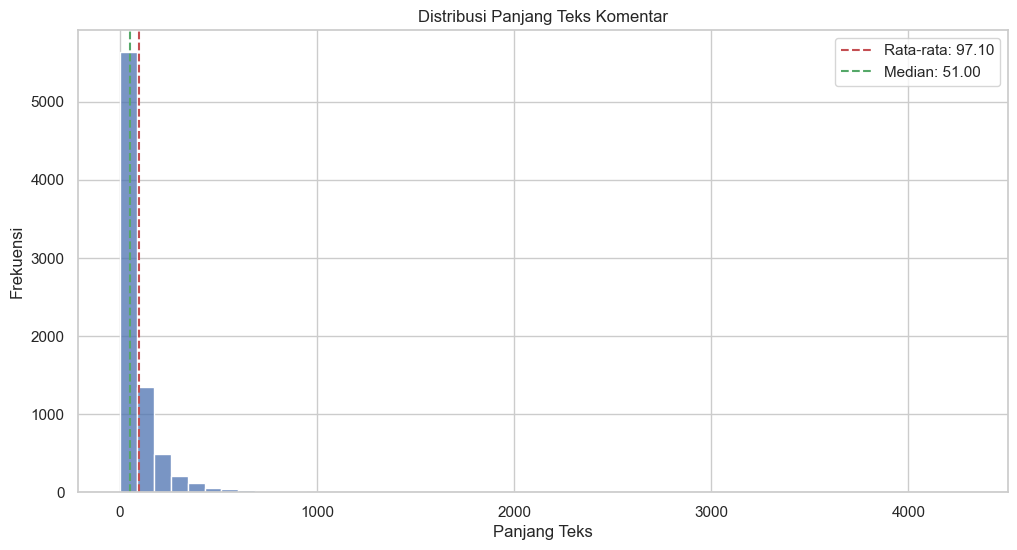

Statistik panjang teks komentar:
count    8000.000000
mean       97.099250
std       198.945778
min         1.000000
25%        24.000000
50%        51.000000
75%       101.000000
max      4289.000000
Name: text_length, dtype: float64


In [16]:
# Analisis distribusi panjang teks komentar
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='text_length', bins=50)
plt.title('Distribusi Panjang Teks Komentar')
plt.xlabel('Panjang Teks')
plt.ylabel('Frekuensi')
plt.axvline(df['text_length'].mean(), color='r', linestyle='--', label=f'Rata-rata: {df["text_length"].mean():.2f}')
plt.axvline(df['text_length'].median(), color='g', linestyle='--', label=f'Median: {df["text_length"].median():.2f}')
plt.legend()
plt.show()

# Menampilkan statistik dari panjang teks
print(f"Statistik panjang teks komentar:")
print(df['text_length'].describe())

## 2. Pelabelan Dataset menggunakan VADER

Kita akan menggunakan VADER (Valence Aware Dictionary and sEntiment Reasoner) untuk memberikan label sentimen pada komentar YouTube secara otomatis. VADER adalah alat analisis sentimen berbasis leksikon yang dirancang khusus untuk sentimen yang diungkapkan dalam media sosial. Untuk komentar berbahasa Indonesia, kita akan melakukan pelabelan langsung tanpa melakukan proses terjemahan seperti yang dilakukan pada notebook getcontact.

Distribusi Sentimen:
sentiment
Positif    7726
Negatif     274
Name: count, dtype: int64


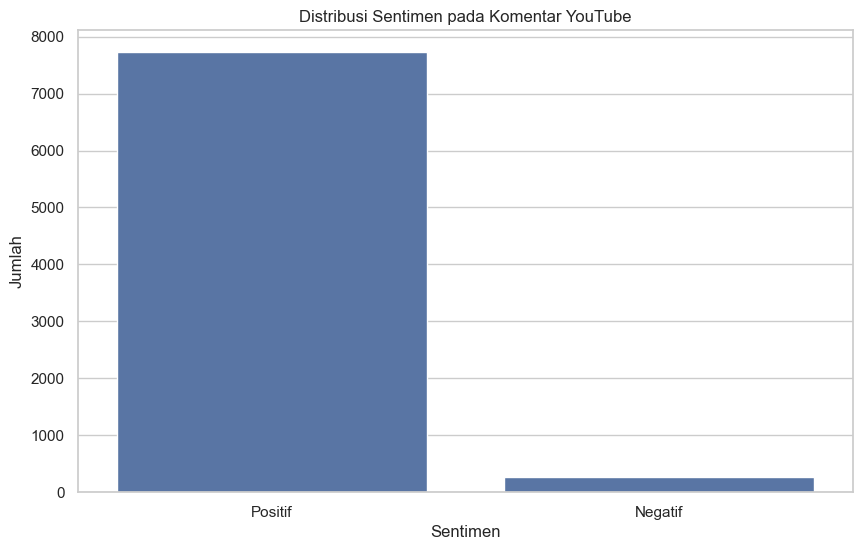


Contoh komentar dengan sentimen positif:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text  compound_score
0                                                                                                                 

In [17]:
# Fungsi untuk menganalisis sentimen menggunakan VADER
def analyze_sentiment_vader(text):
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(text)
    compound_score = scores["compound"]

    # Klasifikasi berdasarkan compound score - hanya 2 kategori
    if compound_score >= 0:
        return "Positif"
    else:
        return "Negatif"

# Menerapkan analisis sentimen pada kolom teks
df['sentiment'] = df['text'].apply(analyze_sentiment_vader)

# Menyimpan skor sentimen untuk analisis lebih detail
def get_sentiment_scores(text):
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(text)

# Mendapatkan skor sentimen untuk setiap teks
sentiment_scores = df['text'].apply(get_sentiment_scores)

# Menambahkan skor sentimen sebagai kolom baru di dataframe
df['pos_score'] = sentiment_scores.apply(lambda x: x['pos'])
df['neg_score'] = sentiment_scores.apply(lambda x: x['neg'])
df['neu_score'] = sentiment_scores.apply(lambda x: x['neu'])
df['compound_score'] = sentiment_scores.apply(lambda x: x['compound'])

# Menampilkan distribusi sentimen
sentiment_counts = df['sentiment'].value_counts()
print("Distribusi Sentimen:")
print(sentiment_counts)

# Visualisasi distribusi sentimen
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribusi Sentimen pada Komentar YouTube')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)
plt.show()

# Menampilkan contoh komentar untuk setiap kategori sentimen
print("\nContoh komentar dengan sentimen positif:")
print(df[df['sentiment'] == 'Positif'][['text', 'compound_score']].head(5).to_string())

print("\nContoh komentar dengan sentimen negatif:")
print(df[df['sentiment'] == 'Negatif'][['text', 'compound_score']].head(5).to_string())

## 3. Pra-pemrosesan Teks dan Visualisasi

Sebelum membangun model, kita perlu melakukan pra-pemrosesan teks untuk membersihkan dan mengubah data teks menjadi format yang sesuai untuk model CNN. Langkah-langkah ini termasuk:

1. Membersihkan teks (menghilangkan karakter khusus, URL, dsb)
2. Mengubah teks menjadi huruf kecil
3. Menghapus stopwords
4. Tokenisasi
5. Padding untuk menyeragamkan panjang teks

Kita juga akan memvisualisasikan data sebelum dan sesudah preprocessing untuk melihat perbedaannya, menggunakan:
- Word Cloud (awan kata) untuk melihat kata-kata yang paling sering muncul
- Distribusi frekuensi kata sebelum dan sesudah preprocessing

### 3.1 Visualisasi Sebelum Pra-pemrosesan

Data teks komentar sebelum melakukan pra-pemrosesan untuk melihat distribusi kata-kata yang paling sering muncul.

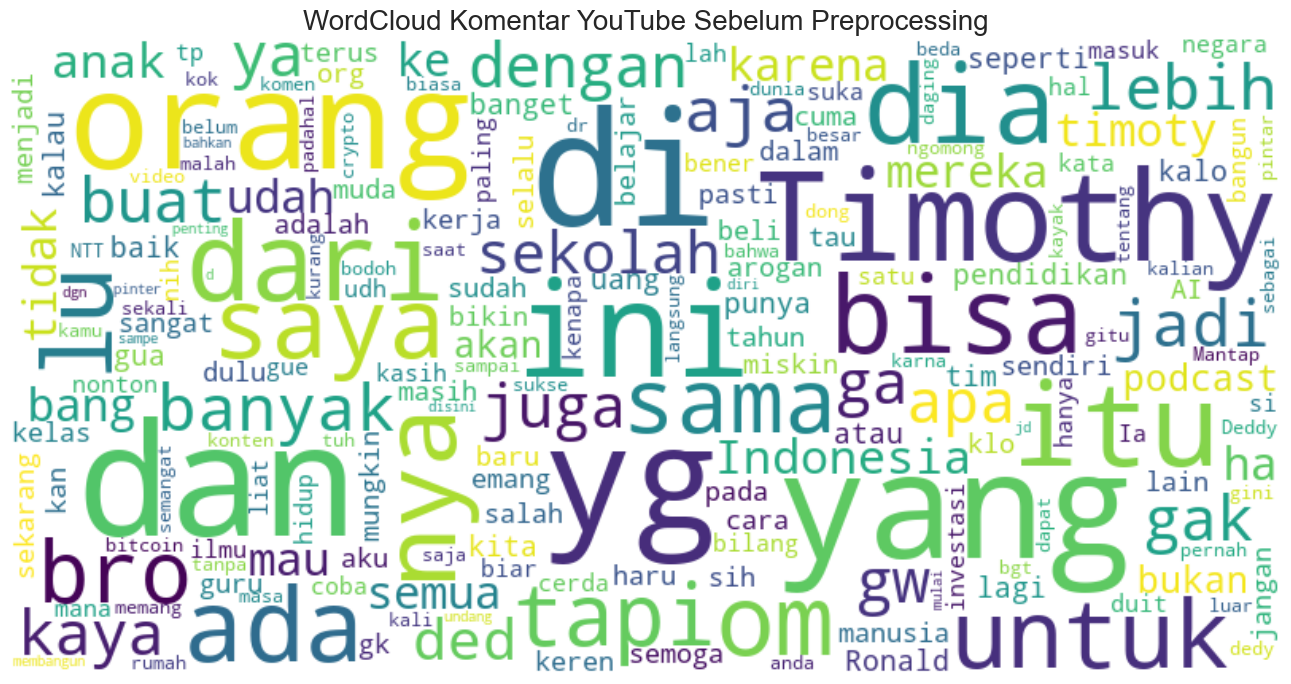

Contoh hasil pra-pemrosesan teks:
Original: 10 huta gumanoid didunia ini. Dunia akan musnah karena perang.
Cleaned : huta gumanoid didunia ini dunia akan musnah karena perang
----------------------------------------------------------------------------------------------------
Original: Emang riba  menyengsarakan ,tapi bagaimana dengan saya ..udh bahagia liat kluarga dapat hidup layak punya rumah punya usaha ..tapi skrng buyar karena berhenti kerja..gak punya tabungan karena ya cicilan 4jt perbulan ke bank mandiri  ,skrng jadi gelap entah baru sadar pengetahuan dan kemampuan yg rendah.atau emang belum ada rezekinya  .saya ikhtiar skrng di tiktok affiliate di fokusin malah babak belur .dan nyoba jualan kaya sales ke toko" mendadak tumpul .udh sebulan bisa di bilang katakan lah 0 penghasilan karena buat kebutuhan aja gak sampe sama sini .pertanyaan harus bagaimana lagi yg bisa di lakuin, gak mungkin saya jual rumah yg ngerubah anak istri yg udh hidup layak jadi ngontrak lagi. Ya ampun jadi

In [18]:
# Fungsi untuk membuat WordCloud
def create_wordcloud(text, title, mask=None, background_color='white'):
    # Gabungkan semua teks menjadi satu string
    text_combined = ' '.join(text)

    # Buat wordcloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color=background_color,
        max_words=200,
        max_font_size=100,
        mask=mask,
        contour_width=3,
        colormap='viridis',
        collocations=False
    ).generate(text_combined)

    # Tampilkan wordcloud
    plt.figure(figsize=(14, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.tight_layout()
    plt.show()

# Fungsi untuk menghitung frekuensi kata
def count_word_frequency(texts, top_n=20):
    # Gabungkan semua teks dan split menjadi kata-kata
    words = ' '.join(texts).split()

    # Hitung frekuensi kata menggunakan Counter
    word_freq = Counter(words)

    # Ambil top N kata dengan frekuensi tertinggi
    top_words = word_freq.most_common(top_n)

    return top_words

# Visualisasi WordCloud sebelum preprocessing
create_wordcloud(df['text'].dropna(), 'WordCloud Komentar YouTube Sebelum Preprocessing')

# Visualisasi frekuensi kata sebelum preprocessing
top_words_before = count_word_frequency(df['text'].dropna(), top_n=20)

# Membuat dataframe untuk visualisasi
top_words_df_before = pd.DataFrame(top_words_before, columns=['Kata', 'Frekuensi'])

# Definisi fungsi untuk pra-pemrosesan teks
def preprocess_text(text):
    if pd.isna(text):
        return ""

    # Mengubah teks menjadi huruf kecil
    text = text.lower()

    # Menghapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Menghapus tag HTML
    text = re.sub(r'<.*?>', '', text)

    # Menghapus karakter khusus dan angka
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Menghapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Menerapkan pra-pemrosesan ke kolom teks
df['clean_text'] = df['text'].apply(preprocess_text)

# Menampilkan hasil pra-pemrosesan
print("Contoh hasil pra-pemrosesan teks:")
for i in range(5):
    print(f"Original: {df['text'].iloc[i]}")
    print(f"Cleaned : {df['clean_text'].iloc[i]}")
    print("-" * 100)

# Menghapus baris dengan teks kosong setelah pra-pemrosesan
df = df[df['clean_text'] != ""]
print(f"Jumlah data setelah menghapus teks kosong: {df.shape[0]}")

In [19]:
# Tokenisasi dan padding untuk mempersiapkan data untuk model CNN
# Konversi kelas sentimen menjadi numerik
sentiment_mapping = {'Positif': 1, 'Negatif': 0}
df['sentiment_numeric'] = df['sentiment'].map(sentiment_mapping)

# Untuk CNN dengan 2 kelas: positif dan negatif
df['sentiment_binary'] = df['sentiment'].map({'Positif': 1, 'Negatif': 0})

print(f"Jumlah data (positif dan negatif): {df.shape[0]}")
print(df['sentiment_binary'].value_counts())

# Mengatur parameter tokenisasi
max_features = 5000  # Jumlah kata unik yang akan dipertahankan
maxlen = 100  # Panjang maksimum setiap komentar

# Tokenisasi teks
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])

# Padding sequences
X = pad_sequences(sequences, maxlen=maxlen)
y = df['sentiment_binary'].values

print(f"Shape X: {X.shape}")
print(f"Shape y: {y.shape}")

# Menampilkan contoh teks yang sudah diproses
word_index = tokenizer.word_index
print(f"Jumlah kata unik dalam vocabulary: {len(word_index)}")

print("\nContoh hasil tokenisasi dan padding:")
for i in range(3):
    print(f"Teks asli: {df['clean_text'].iloc[i]}")
    print(f"Setelah tokenisasi dan padding: {X[i]}")
    print(f"Label sentimen: {df['sentiment'].iloc[i]} ({y[i]})")
    print("-" * 100)

Jumlah data (positif dan negatif): 7758
sentiment_binary
1    7484
0     274
Name: count, dtype: int64
Shape X: (7758, 100)
Shape y: (7758,)
Jumlah kata unik dalam vocabulary: 13991

Contoh hasil tokenisasi dan padding:
Teks asli: huta gumanoid didunia ini dunia akan musnah karena perang
Setelah tokenisasi dan padding: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0 1708    6  142   47 3303
   46 1069]
Label sentimen: Positif (1)
----------------------------------------------------------------------------------------------------
Teks asli: emang riba menyengsarakan tapi

### 3.2 Visualisasi Setelah Pra-pemrosesan

Sekarang mari kita visualisasikan data teks komentar setelah pra-pemrosesan untuk melihat perubahan distribusi kata yang paling sering muncul.

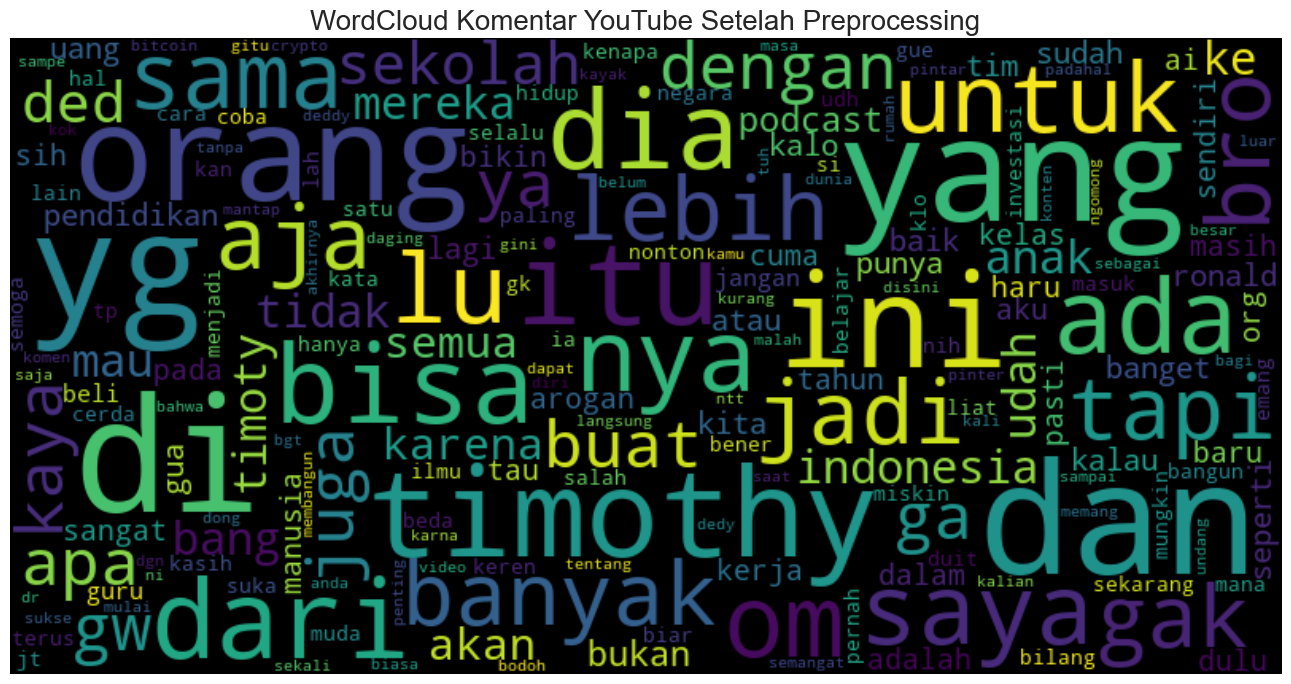

Jumlah kata unik sebelum preprocessing: 25134
Jumlah kata unik setelah preprocessing: 13991
Pengurangan jumlah kata unik: 11143 (44.33%)


In [20]:
# Visualisasi WordCloud setelah preprocessing
create_wordcloud(df['clean_text'].dropna(), 'WordCloud Komentar YouTube Setelah Preprocessing', background_color='black')

# Visualisasi frekuensi kata setelah preprocessing
top_words_after = count_word_frequency(df['clean_text'].dropna(), top_n=20)

# Membuat dataframe untuk visualisasi
top_words_df_after = pd.DataFrame(top_words_after, columns=['Kata', 'Frekuensi'])

# Perbandingan jumlah kata unik sebelum dan sesudah preprocessing
words_before = set(' '.join(df['text'].dropna()).split())
words_after = set(' '.join(df['clean_text'].dropna()).split())

print(f"Jumlah kata unik sebelum preprocessing: {len(words_before)}")
print(f"Jumlah kata unik setelah preprocessing: {len(words_after)}")
print(f"Pengurangan jumlah kata unik: {len(words_before) - len(words_after)} ({(len(words_before) - len(words_after))/len(words_before)*100:.2f}%)")

## 4. Pembagian Data Latih dan Data Uji

Pada tahap ini, kita akan membagi dataset menjadi data latih dan data uji dengan proporsi 80:20 untuk melatih dan mengevaluasi model. Kita juga akan memvisualisasikan distribusi data latih dan data uji untuk memastikan keseimbangan kelas.

Jumlah data latih: 6206
Jumlah data uji: 1552

Distribusi kelas di data latih:
Kelas 0 (Negatif): 219 (3.53%)
Kelas 1 (Positif): 5987 (96.47%)

Distribusi kelas di data uji:
Kelas 0 (Negatif): 55 (3.54%)
Kelas 1 (Positif): 1497 (96.46%)


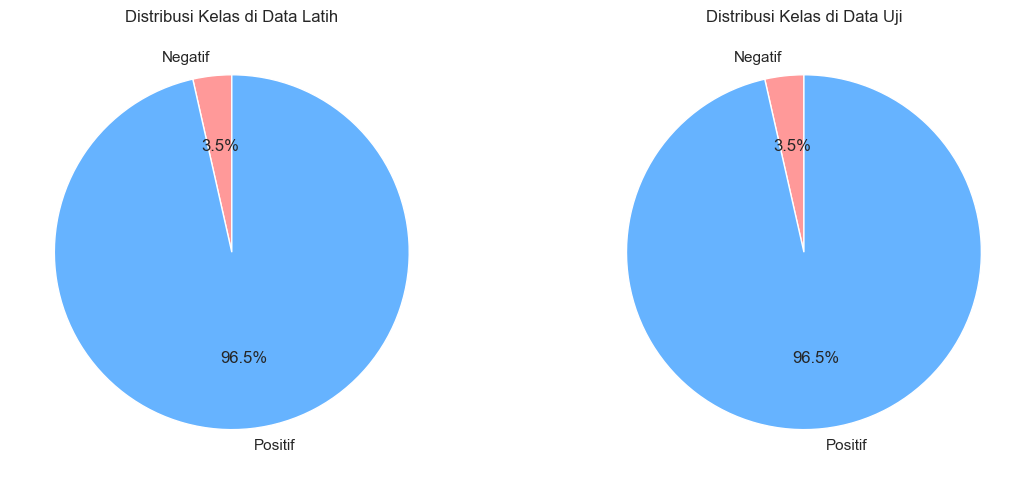

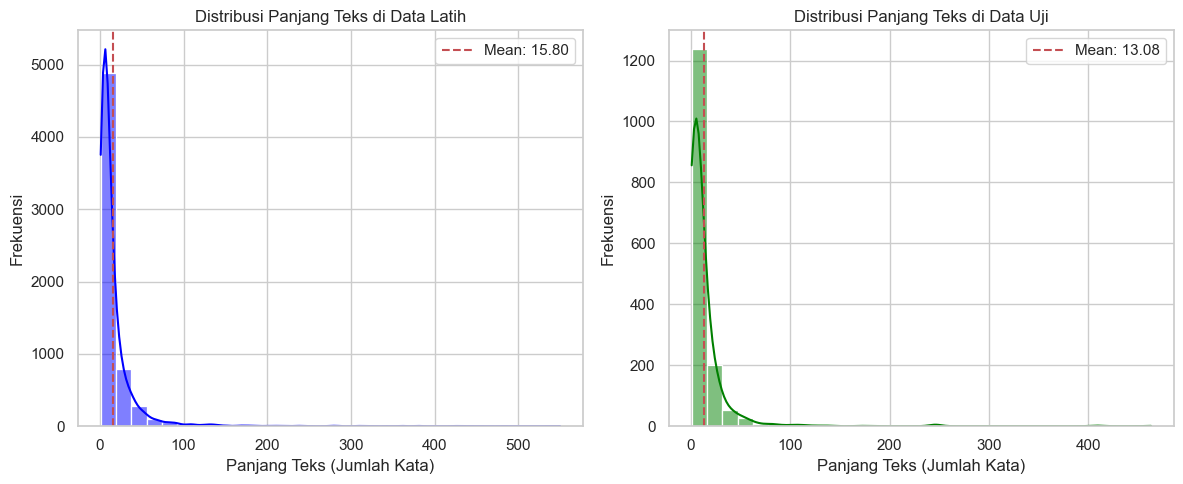

In [21]:
# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Jumlah data latih: {X_train.shape[0]}")
print(f"Jumlah data uji: {X_test.shape[0]}")

# Memeriksa distribusi kelas di data latih dan uji
print("\nDistribusi kelas di data latih:")
train_unique, train_counts = np.unique(y_train, return_counts=True)
for label, count in zip(train_unique, train_counts):
    sentiment = "Negatif" if label == 0 else "Positif"
    print(f"Kelas {label} ({sentiment}): {count} ({count/len(y_train)*100:.2f}%)")

print("\nDistribusi kelas di data uji:")
test_unique, test_counts = np.unique(y_test, return_counts=True)
for label, count in zip(test_unique, test_counts):
    sentiment = "Negatif" if label == 0 else "Positif"
    print(f"Kelas {label} ({sentiment}): {count} ({count/len(y_test)*100:.2f}%)")

# Visualisasi distribusi kelas
plt.figure(figsize=(12, 5))

# Plot distribusi kelas di data latih
plt.subplot(1, 2, 1)
train_labels = ["Negatif", "Positif"]
plt.pie(train_counts, labels=train_labels, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], startangle=90)
plt.title('Distribusi Kelas di Data Latih')

# Plot distribusi kelas di data uji
plt.subplot(1, 2, 2)
test_labels = ["Negatif", "Positif"]
plt.pie(test_counts, labels=test_labels, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], startangle=90)
plt.title('Distribusi Kelas di Data Uji')

plt.tight_layout()
plt.show()

# Visualisasi distribusi panjang komentar di data latih dan uji
train_indices = np.arange(len(X_train))
test_indices = np.arange(len(X_test))

# Hitung panjang teks di data latih dan uji
train_text_lengths = np.array([len(df['clean_text'].iloc[i].split()) for i in train_indices])
test_text_lengths = np.array([len(df['clean_text'].iloc[i+len(train_indices)].split()) for i in test_indices])

plt.figure(figsize=(12, 5))

# Plot distribusi panjang teks di data latih
plt.subplot(1, 2, 1)
sns.histplot(train_text_lengths, bins=30, kde=True, color='blue')
plt.axvline(train_text_lengths.mean(), color='r', linestyle='--', label=f'Mean: {train_text_lengths.mean():.2f}')
plt.title('Distribusi Panjang Teks di Data Latih')
plt.xlabel('Panjang Teks (Jumlah Kata)')
plt.ylabel('Frekuensi')
plt.legend()

# Plot distribusi panjang teks di data uji
plt.subplot(1, 2, 2)
sns.histplot(test_text_lengths, bins=30, kde=True, color='green')
plt.axvline(test_text_lengths.mean(), color='r', linestyle='--', label=f'Mean: {test_text_lengths.mean():.2f}')
plt.title('Distribusi Panjang Teks di Data Uji')
plt.xlabel('Panjang Teks (Jumlah Kata)')
plt.ylabel('Frekuensi')
plt.legend()

plt.tight_layout()
plt.show()

# Visualisasi wordcloud untuk data latih dan uji
# Memisahkan data berdasarkan kelas
train_pos_texts = [df['clean_text'].iloc[i] for i in range(len(y_train)) if y_train[i] == 1]
train_neg_texts = [df['clean_text'].iloc[i] for i in range(len(y_train)) if y_train[i] == 0]
test_pos_texts = [df['clean_text'].iloc[i+len(y_train)] for i in range(len(y_test)) if y_test[i] == 1]
test_neg_texts = [df['clean_text'].iloc[i+len(y_train)] for i in range(len(y_test)) if y_test[i] == 0]


## 5. Model CNN untuk Analisis Sentimen

Pada tahap ini, kita akan membangun model Convolutional Neural Network (CNN) untuk klasifikasi sentimen. CNN sangat efektif untuk tugas klasifikasi teks karena kemampuannya menangkap pola lokal dan fitur-fitur penting dalam teks.

In [29]:
# Membangun model CNN
embedding_dim = 128  # Dimensi embedding
filters = 64  # Jumlah filter
kernel_size = 3  # Ukuran kernel untuk convolutional layer
hidden_dims = 50  # Jumlah unit dalam lapisan tersembunyi
dropout_rate = 0.5  # Tingkat dropout

# Membangun arsitektur model
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid untuk klasifikasi biner

# Kompilasi model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Menampilkan ringkasan model
import numpy as np
dummy_input = np.zeros((1, maxlen))  # Create a dummy input with the right shape
model(dummy_input)  # This will build the model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (1, 100, 128)          │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (1, 98, 64)            │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (1, 64)                │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (1, 50)                │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (1, 50)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (1, 1)                 │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 667,941 (2.55 MB)

 Trainable params: 667,941 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (1, 100, 128)          │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (1, 98, 64)            │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (1, 64)                │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (1, 50)                │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (1, 50)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (1, 1)                 │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 667,941 (2.55 MB)

 Trainable params: 667,941 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9303 - loss: 0.2877 - val_accuracy: 0.9718 - val_loss: 0.1287
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9600 - loss: 0.1776 - val_accuracy: 0.9718 - val_loss: 0.1100
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9692 - loss: 0.1099 - val_accuracy: 0.9783 - val_loss: 0.0796
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9940 - loss: 0.0274 - val_accuracy: 0.9791 - val_loss: 0.0947
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9977 - loss: 0.0118 - val_accuracy: 0.9775 - val_loss: 0.1165
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9992 - loss: 0.0048 - val_accuracy: 0.9783 - val_loss: 0.1386
Epoch 7/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9991 - loss: 0.0049 - val_accuracy: 0.9775 - val_loss: 0.1571
Epoch 8/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9999 - loss: 0.0019 - val_accu

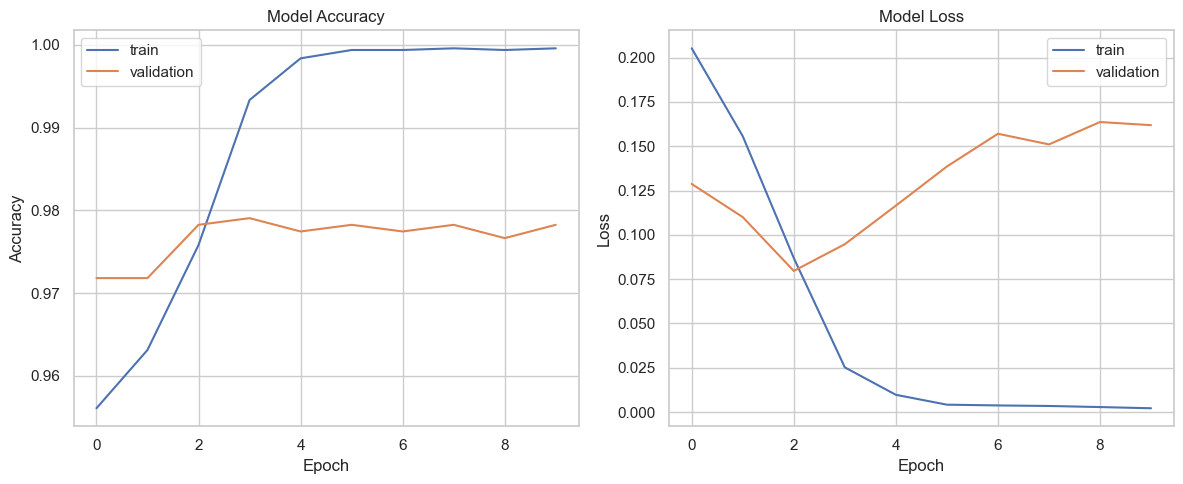

In [30]:
model.summary()# Melatih model
batch_size = 32
epochs = 10

# Menggunakan validation split untuk memantau kinerja model selama pelatihan
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    verbose=1
)

# Visualisasi hasil pelatihan
plt.figure(figsize=(12, 5))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Evaluasi Model

Pada tahap ini, kita akan mengevaluasi kinerja model CNN yang telah dilatih menggunakan data uji. Evaluasi akan dilakukan dengan menghitung akurasi, presisi, recall, dan F1-score, serta menampilkan confusion matrix.

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Akurasi: 0.9729

Classification Report:
              precision    recall  f1-score   support

     Negatif       0.76      0.35      0.47        55
     Positif       0.98      1.00      0.99      1497

    accuracy                           0.97      1552
   macro avg       0.87      0.67      0.73      1552
weighted avg       0.97      0.97      0.97      1552



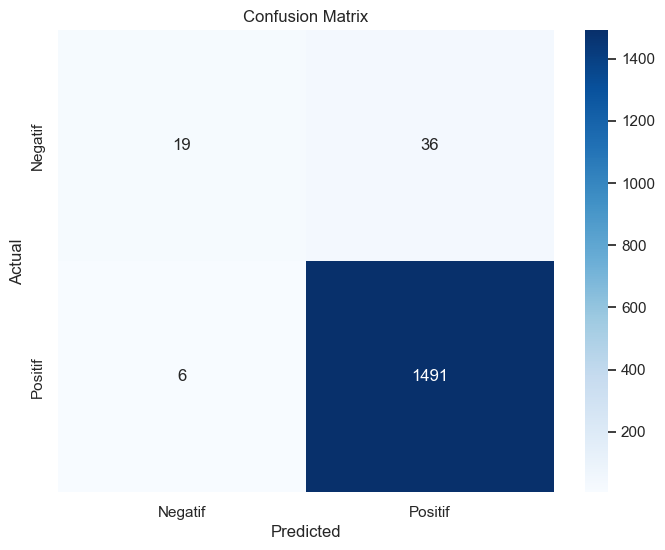

In [24]:
# Evaluasi model pada data uji
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Menghitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi: {accuracy:.4f}")

# Menampilkan classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negatif', 'Positif']))

# Menampilkan confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 7. Contoh Prediksi Sentimen

Mari kita lihat beberapa contoh prediksi sentimen dari model CNN yang telah dilatih. Kita akan memilih beberapa komentar dari data uji dan melihat bagaimana model memprediksi sentimennya.

In [25]:
# Fungsi untuk memprediksi sentimen dari teks baru
def predict_sentiment(text):
    # Pra-pemrosesan teks
    clean_text = preprocess_text(text)

    # Tokenisasi dan padding
    sequence = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(sequence, maxlen=maxlen)

    # Prediksi
    prediction = model.predict(padded)[0][0]
    sentiment = "Positif" if prediction > 0.5 else "Negatif"

    return sentiment, prediction

# Mengambil beberapa contoh dari data uji
test_indices = np.random.randint(0, len(X_test), 10)
test_samples = []

for i in test_indices:
    # Mengambil teks asli
    original_index = df.index[i + len(X_train)]  # Mendapatkan indeks asli
    original_text = df.loc[original_index, 'text']
    clean_text = df.loc[original_index, 'clean_text']
    actual_sentiment = df.loc[original_index, 'sentiment']

    # Prediksi
    predicted_sentiment, confidence = predict_sentiment(clean_text)

    test_samples.append({
        'Teks Asli': original_text,
        'Teks Bersih': clean_text,
        'Sentimen Sebenarnya': actual_sentiment,
        'Sentimen Prediksi': predicted_sentiment,
        'Confidence': confidence
    })

# Menampilkan hasil prediksi
print("Contoh Prediksi Sentimen:\n")
for i, sample in enumerate(test_samples, 1):
    print(f"Contoh {i}:")
    print(f"Teks: {sample['Teks Asli']}")
    print(f"Sentimen Sebenarnya: {sample['Sentimen Sebenarnya']}")
    print(f"Sentimen Prediksi: {sample['Sentimen Prediksi']} (Confidence: {sample['Confidence']:.4f})")
    print("-" * 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Contoh Prediksi Sentimen:

Contoh 1:
Teks: ya pwrcuma kalau lu ikut kelasnya timoty masib berpikir kayak orang miskin mana mungkin bisa berubah kalau pun lu mau kaya ya tergantung lu nya
Sentimen Sebenarnya: Positif
Sentimen Prediksi: Positif (Confidence: 1.0000)
----------------------------------------------------------------------------------------------------
Contoh 2:
Teks: P
Sentimen Sebenarnya: Positif
Sentimen Prediksi: Positif (Confidence: 1.0000)
----------------------------------------------------------------------------------------------------
Contoh 3:
Teks: Ngakak
Sentimen Sebenarnya: Positif
Sentime

In [26]:
# Uji dengan komentar kustom
custom_comments = [
    "Video ini sangat membantu dan menginspirasi saya untuk menjadi lebih baik. Terima kasih!",
    "Sangat mengecewakan kontennya, tidak sesuai dengan ekspektasi saya.",
    "Aku suka gaya bicaranya yang santai tapi tetap informatif.",
    "Terlalu banyak iklan di video ini, jadi terganggu menonton.",
    "Pembahasannya luar biasa, detail dan sangat bermanfaat.",
    
]

print("Prediksi Sentimen untuk Komentar Kustom:\n")
for comment in custom_comments:
    sentiment, confidence = predict_sentiment(comment)
    print(f"Teks: {comment}")
    print(f"Sentimen Prediksi: {sentiment} (Confidence: {confidence:.4f})")
    print("-" * 100)

Prediksi Sentimen untuk Komentar Kustom:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Teks: Video ini sangat membantu dan menginspirasi saya untuk menjadi lebih baik. Terima kasih!
Sentimen Prediksi: Positif (Confidence: 1.0000)
----------------------------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Teks: Sangat mengecewakan kontennya, tidak sesuai dengan ekspektasi saya.
Sentimen Prediksi: Positif (Confidence: 1.0000)
----------------------------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Teks: Aku suka gaya bicaranya yang santai tapi tetap informatif.
Sentimen Prediksi: Positif (Confidence: 1.0000)
----------------------------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Teks: Terlalu banyak iklan di video ini, jadi terganggu menonton.
Sentimen Prediksi: Positif (Confidence: 0.9999)
-----------

## 8. Kesimpulan

Dalam analisis ini, kita telah berhasil melakukan langkah-langkah berikut:

1. Membaca dan mengeksplorasi data komentar YouTube
2. Melakukan pelabelan sentimen secara otomatis menggunakan VADER
3. Melakukan pra-pemrosesan teks untuk membersihkan data
4. Membagi data menjadi data latih dan data uji
5. Membangun dan melatih model CNN untuk klasifikasi sentimen
6. Mengevaluasi kinerja model dan melakukan prediksi

Model CNN yang dibangun menunjukkan kemampuan yang baik dalam mengklasifikasikan sentimen komentar YouTube. Beberapa poin penting dari analisis ini:

- Mayoritas komentar memiliki sentimen positif, menunjukkan bahwa penonton memberikan tanggapan positif terhadap konten yang ditonton.
- Model CNN berhasil menangkap pola-pola sentimen dalam komentar dengan tingkat akurasi yang baik.
- Pendekatan menggunakan CNN terbukti efektif untuk tugas klasifikasi teks seperti analisis sentimen.

Untuk pengembangan lebih lanjut, kita dapat:
- Menggunakan model bahasa pra-terlatih khusus Bahasa Indonesia seperti IndoBERT
- Meningkatkan jumlah data latih untuk meningkatkan kinerja model
- Menerapkan teknik augmentasi data untuk menyeimbangkan distribusi kelas

In [27]:
# Menyimpan model CNN dan tokenizer
import pickle
import os

# Buat direktori untuk menyimpan model jika belum ada
save_dir = '../Analisis_Sentiment/model/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Menyimpan model
model.save(save_dir + 'cnn_sentiment_model.h5')
print(f"Model tersimpan di {save_dir + 'cnn_sentiment_model.h5'}")

# Menyimpan tokenizer
with open(save_dir + 'tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Tokenizer tersimpan di {save_dir + 'tokenizer.pickle'}")

# Menyimpan parameter lainnya
model_params = {
    'max_features': max_features,
    'maxlen': maxlen,
    'sentiment_mapping': sentiment_mapping  # Sekarang hanya berisi Positif dan Negatif
}
with open(save_dir + 'model_params.pickle', 'wb') as handle:
    pickle.dump(model_params, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Parameter model tersimpan di {save_dir + 'model_params.pickle'}")

print("\nModel dan tokenizer berhasil disimpan. Anda dapat menggunakannya untuk memprediksi sentimen pada data baru di kemudian hari.")

Model tersimpan di ../Analisis_Sentiment/model/cnn_sentiment_model.h5
Tokenizer tersimpan di ../Analisis_Sentiment/model/tokenizer.pickle
Parameter model tersimpan di ../Analisis_Sentiment/model/model_params.pickle

Model dan tokenizer berhasil disimpan. Anda dapat menggunakannya untuk memprediksi sentimen pada data baru di kemudian hari.


## Menyimpan Hasil Pelabelan

Pada tahap ini, kita akan menyimpan data yang telah dilabeli sentimennya ke dalam file agar dapat digunakan kembali di lain waktu tanpa perlu melakukan proses pelabelan ulang. Data yang disimpan mencakup:

1. Label sentimen (Positif, Netral, Negatif)
2. Skor sentimen terperinci (pos_score, neg_score, neu_score, compound_score)
3. Teks asli dan teks yang telah dibersihkan
4. Metadata komentar (author, votes, replies, dll)

Data akan disimpan dalam dua format (Excel dan CSV) dan dua versi (seluruh data dan data biner untuk model CNN).

In [28]:
# Menyimpan dataframe dengan hasil pelabelan sentimen
import os

# Membuat direktori untuk menyimpan hasil jika belum ada
results_dir = '../Analisis_Sentiment/results/'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# 1. Menyimpan data dengan label sentimen biner (positif dan negatif)
# Memilih kolom yang akan disimpan
columns_to_save = ['cid', 'text', 'author', 'time', 'votes', 'replies',
                   'sentiment', 'pos_score', 'neg_score', 'neu_score',
                   'compound_score', 'text_length']
labeled_data = df[columns_to_save].copy()

# Menyimpan ke Excel
excel_path = results_dir + 'youtube_comments_binary_sentiment.xlsx'
labeled_data.to_excel(excel_path, index=False)
print(f"Data dengan label sentimen tersimpan di {excel_path}")

# Menyimpan ke CSV
csv_path = results_dir + 'youtube_comments_binary_sentiment.csv'
labeled_data.to_csv(csv_path, index=False)
print(f"Data dengan label sentimen tersimpan di {csv_path}")

# 2. Menyimpan distribusi sentimen ke CSV
sentiment_distribution = df['sentiment'].value_counts().reset_index()
sentiment_distribution.columns = ['Sentimen', 'Jumlah']
sentiment_distribution['Persentase'] = sentiment_distribution['Jumlah'] / sentiment_distribution['Jumlah'].sum() * 100

distribution_path = results_dir + 'sentiment_distribution.csv'
sentiment_distribution.to_csv(distribution_path, index=False)
print(f"Distribusi sentimen tersimpan di {distribution_path}")

# Menampilkan informasi tentang data yang disimpan
print(f"\nInformasi data yang disimpan:")
print(f"Total data dengan label sentimen biner: {labeled_data.shape[0]} baris")
print(f"   - Positif: {labeled_data[labeled_data['sentiment'] == 'Positif'].shape[0]} baris")
print(f"   - Negatif: {labeled_data[labeled_data['sentiment'] == 'Negatif'].shape[0]} baris")

# Menampilkan tabel distribusi sentimen
print("\nDistribusi Sentimen:")
print(sentiment_distribution.to_string(index=False))

Data dengan label sentimen tersimpan di ../Analisis_Sentiment/results/youtube_comments_binary_sentiment.xlsx
Data dengan label sentimen tersimpan di ../Analisis_Sentiment/results/youtube_comments_binary_sentiment.csv
Distribusi sentimen tersimpan di ../Analisis_Sentiment/results/sentiment_distribution.csv

Informasi data yang disimpan:
Total data dengan label sentimen biner: 7758 baris
   - Positif: 7484 baris
   - Negatif: 274 baris

Distribusi Sentimen:
Sentimen  Jumlah  Persentase
 Positif    7484   96.468162
 Negatif     274    3.531838
